# Chapter 2 Exercises

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

## Question 1
***

*Using PyMC3, change the parameters of the prior beta distribution in `our_first_model` to match those of the previous chapter. Compare the results to the previous chapter. Replace the beta distribution with a uniform one in the interval [0,1]. Are the results equivalent to $Beta(\alpha=1, \beta=1)$? Is the sampling slower, faster or the same? What about using a larger interval, such as [-1,2]? Does the model run? What errors do you get?*

In [2]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = dist.Bernoulli(probs=theta_real).sample(random.PRNGKey(123), sample_shape=(trials,))
# data = stats.bernoulli.rvs(p=theta_real, size=trials)

### Baseline model
First let us set a baseline model with a $\alpha =1, \beta=1$ prior. We'll give $\theta$ a more verbose name to be able to more easily identify it later. It should be noted that string variable names do not have to the same as the object name.

When evaluating each model the strategy will be the same.
1. Run the model
2. Read the warning messages
3. View the posterior kernel density estimate and traceplot
4. Inspect the numerical summary

In [3]:
def model(obs=None):
    # a priori
    θ = numpyro.sample('θ Beta(alpha=1, beta=1)', dist.Beta(concentration1=1., concentration0=1.))
    # likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
    
kernel = NUTS(model)
mcmc_baseline = MCMC(kernel, num_warmup=500, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc_baseline.run(random.PRNGKey(1), obs=data)

sample: 100%|██████████████████████████| 5500/5500 [00:00<00:00, 7554.77it/s, 3 steps of size 8.88e-01. acc. prob=0.91]


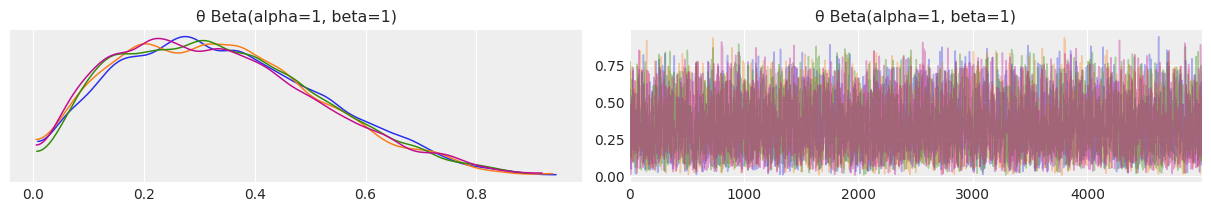

In [4]:
az.plot_trace(mcmc_baseline, compact=False);

In [5]:
baseline_model = az.summary(mcmc_baseline)
baseline_model

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"θ Beta(alpha=1, beta=1)",0.336,0.179,0.025,0.654,0.002,0.002,6644.0,8142.0,1.0


### Match prior for previous example

In [6]:
# Picking first parameters from page 28
def model(obs=None):
    # a priori
    θ = numpyro.sample("θ", dist.Beta(concentration1=1, concentration0=1))
    # likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(1), obs=data)

sample: 100%|██████████████████████████| 5500/5500 [00:00<00:00, 7260.89it/s, 3 steps of size 8.88e-01. acc. prob=0.91]


### Replace the beta distribution with a uniform one in the interval [0,1]

In [7]:
# Picking first parameters from page 28
def model(obs=None):
    # a priori
    θ = numpyro.sample('θ Uniform(0,1)', dist.Uniform(low=0, high=1))
    # likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)

kernel = NUTS(model)
mcmc_uniform = MCMC(kernel, num_warmup=500, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc_uniform.run(random.PRNGKey(1), obs=data)

sample: 100%|██████████████████████████| 5500/5500 [00:00<00:00, 7762.11it/s, 3 steps of size 1.20e+00. acc. prob=0.88]


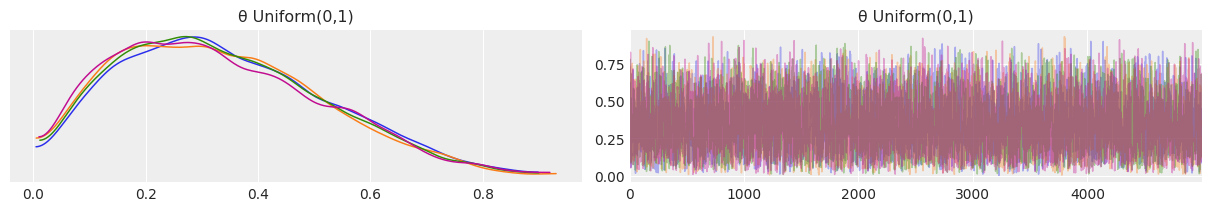

In [8]:
az.plot_trace(mcmc_uniform, compact=False);

In [9]:
uniform_prior_0_1 = az.summary(mcmc_uniform)
pd.concat([baseline_model, uniform_prior_0_1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"θ Beta(alpha=1, beta=1)",0.336,0.179,0.025,0.654,0.002,0.002,6644.0,8142.0,1.0
"θ Uniform(0,1)",0.334,0.180,0.030,0.656,0.002,0.001,7436.0,8597.0,1.0


### Discussion
Both priors produce identical results. This is to be expected as a $Beta(1,1)$ prior is exactly the same as a $Uniform(0,1)$ prior. I encourage you to prove it to yourself by plotting both. Furthermore, the models sampling times are identical as well.

### Replace the beta distribution with a uniform  [-1,2]

In [10]:
def model(obs=None):
    # a priori
    θ = numpyro.sample('θ Uniform(-1,1)', dist.Uniform(low=-1, high=2))
    # likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)

kernel = NUTS(model)
mcmc_uniform_minus_1_2 = MCMC(kernel, num_warmup=500, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc_uniform_minus_1_2.run(random.PRNGKey(1), obs=data)

sample: 100%|██████████████████████████| 5500/5500 [00:00<00:00, 7372.29it/s, 3 steps of size 1.05e+00. acc. prob=0.84]


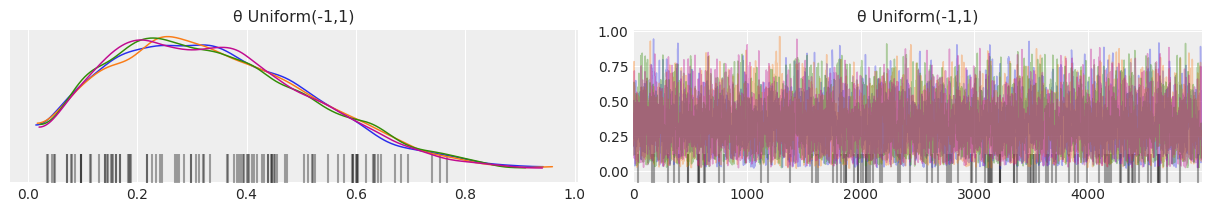

In [11]:
az.plot_trace(mcmc_uniform_minus_1_2, compact=False);

In [12]:
uniform_prior_minus_1_2 = az.summary(mcmc_uniform_minus_1_2)
pd.concat([baseline_model, uniform_prior_minus_1_2])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"θ Beta(alpha=1, beta=1)",0.336,0.179,0.025,0.654,0.002,0.002,6644.0,8142.0,1.0
"θ Uniform(-1,1)",0.335,0.178,0.022,0.637,0.002,0.002,6041.0,7257.0,1.0


### Discussion
Looking at the mean, sd, and HPD values, both results look identical, which is great. However there are three items that raise concerns. We will cover these in depth in Chapter 8 but will note them here as part of the exercise.

The first is that there are two new warning messages that look something like `There were 1179 divergences after tuning. Increase target_accept or reparameterize`. Here, the sampler is warning us that something is going wrong with sampling.

The second is the black bars at the bottom of the traceplot. These also indicate divergences.

Lastly, when looking at eff_n, which stands for effective number of samples, the $Uniform(-1,2)$ prior has a much lower number than the $Beta(1,1)$, meaning that the number of useful samples was much less than the total number of samples drawn.

This makes sense when asking the question "Can a probabiity be less than 0 or more than 1?". The answer is no, but in our prior we're asking the sampler to "test" prior probability values less than 0 and greater than 1, and when it does so the likelihood function is unable to compute a value.

Again, we'll cover MCMC diagnostics (and what to do) in much more detail in Chapter 8, but for now it is sufficient to be able to recognize these warnings when they appear.

## Question 2
***

*Read about the [coal mining disaster model](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters) that is part of the PyMC3 documentation. Try to implement and run this model by yourself.*

## Question 3
***

*Modify `model_g`: change the prior for the mean to a Gaussian distribution centered at the empirical mean, and play with a couple of reasonable values for the standard deviation of this prior. How robust/sensitive are the inferences to these changes? What do you think of using a Gaussian, which is an unbounded distribution (goes from $-\infty$ to $+\infty$), to model bouded data such as this? Remember that we said it is not possible to get values below 0 or above 100.*

First let's load the data and calculate the mean and standard deviation

In [13]:
data = pd.read_csv('../data/chemical_shifts.csv', header=None)
data.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [14]:
data = jnp.asarray(data)

In [15]:
empirical_mean = jnp.mean(data)
empirical_std = jnp.std(data)
empirical_mean, empirical_std

(DeviceArray(53.496456, dtype=float32), DeviceArray(3.4200068, dtype=float32))

Next, let's create a model with a prior parametrized by $\mu \text{~} N(53, \sigma)$. Since we want to test the effect of various $\sigma$ values, we'll assume that values of [1.5, 3.0, 5.0] are reasonable priors parameters. We'll also add one unreasonable $sigma$ of 1000 for comparison.

A benefit of Python is that we can create a loop to run three models and compare results.

In [16]:
summaries = []
sd_priors = [1.5, 3, 5, 1000]

In [17]:
for sd_prior in sd_priors:
    def model(obs=None):
        # Modified prior to Gaussian
        μ = numpyro.sample(f'μ_prior_{sd_prior}', dist.Normal(loc=empirical_mean, scale=sd_prior))
        σ = numpyro.sample('σ', dist.HalfNormal(scale=10))
        # Likelihood
        y = numpyro.sample('y', dist.Normal(loc=μ, scale=σ), obs=obs)
        
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4, chain_method='sequential')
    mcmc.run(random.PRNGKey(1), obs=data)
    summaries.append(az.summary(mcmc))

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 6858.02it/s, 3 steps of size 9.82e-01. acc. prob=0.90]


In [18]:
pd.concat(summaries)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_prior_1.5,53.495,0.487,52.600,54.477,0.008,0.006,3521.0,2716.0,1.0
σ,3.533,0.378,2.884,4.254,0.007,0.005,2732.0,2464.0,1.0
μ_prior_3,53.492,0.510,52.496,54.447,0.009,0.006,3146.0,2358.0,1.0
σ,3.554,0.389,2.862,4.280,0.008,0.006,2652.0,2167.0,1.0
μ_prior_5,53.496,0.499,52.581,54.483,0.008,0.006,3514.0,2809.0,1.0
σ,3.544,0.372,2.875,4.242,0.007,0.005,2554.0,2167.0,1.0
μ_prior_1000,53.483,0.516,52.441,54.448,0.009,0.006,3205.0,2635.0,1.0
σ,3.544,0.381,2.805,4.216,0.008,0.005,2587.0,2404.0,1.0


Looking at the summaries, the combination of model and inference technique seem quite robust to the changes. Even with a prior that is 300x larger than the empirical prior, the posterior values converge to approximately the same result. Computationally there seems to be very little difference.

Logically however, there could be some question about the choice of an unbounded prior. Since it is not possible to get values below 0 or above 100, it doesn't make practical sense to have a prior that exists for those values. Luckily though, with modern inference methods such as NUTS, the samples can "bypass" questionable priors and still get a good approximation of the posterior.

## Question 4
***

*Using the data in chemical_shifts.csv, compute the empirical mean and the standard deviation with and without outliers. Repeat the exercise by adding more outliers. Compare those results to the Bayesian estimations using the Gaussian and Student's t distributions from the chapter.*

Let's first compute the mean and standard deviation without removing any data:

In [19]:
data = pd.read_csv('../data/chemical_shifts.csv', header=None)
data = jnp.asarray(data)
empirical_mean, empirical_std = jnp.mean(data), jnp.std(data)
empirical_mean, empirical_std

(DeviceArray(53.496456, dtype=float32), DeviceArray(3.4200068, dtype=float32))

Then let's let's identify outliers by using the _2x standard deviation_ methodology:

In [20]:
outlier_mask = ~(jnp.abs(data-empirical_mean) < empirical_std*2)
data[outlier_mask]

DeviceArray([63.43, 68.58], dtype=float32)

Removing those two values, let's recompute the mean and standard deviation:

In [21]:
empirical_mean_no_outliers = jnp.mean(data[~outlier_mask])
empirical_std_no_outliers = jnp.std(data[~outlier_mask])

empirical_mean_no_outliers, empirical_std_no_outliers

(DeviceArray(52.95261, dtype=float32), DeviceArray(2.1950302, dtype=float32))

Notice that the mean has dropped from 53.49 to 52.95, and the standard deviation has dropped from 3.42 to 2.19. Logically this makes sense as the data is "less spread out" when we don't include  outliers.

Let's repeat the exercise but add more outliers. We can do this by repeating the previously identified outliers a couple more times:

In [22]:
# Create an array with the outliers repeated 4 times
additional_outliers = jnp.repeat(data[outlier_mask],4)

# Concatenate the original data array and the additional outliers
data_more_outliers = jnp.concatenate([data, jnp.expand_dims(additional_outliers, axis=1)])
data_more_outliers

DeviceArray([[51.06],
             [55.12],
             [53.73],
             [50.24],
             [52.05],
             [56.4 ],
             [48.45],
             [52.34],
             [55.65],
             [51.49],
             [51.86],
             [63.43],
             [53.  ],
             [56.09],
             [51.93],
             [52.31],
             [52.33],
             [57.48],
             [57.44],
             [55.14],
             [53.93],
             [54.62],
             [56.09],
             [68.58],
             [51.36],
             [55.47],
             [50.73],
             [51.94],
             [54.95],
             [50.39],
             [52.91],
             [51.5 ],
             [52.68],
             [47.72],
             [49.73],
             [51.82],
             [54.99],
             [52.84],
             [53.19],
             [54.52],
             [51.46],
             [53.73],
             [51.61],
             [49.81],
             [52.42],
          

In [23]:
empirical_mean_more_outliers = jnp.mean(data_more_outliers)
empirical_std_more_outliers = jnp.std(data_more_outliers)

empirical_mean_more_outliers, empirical_std_more_outliers

(DeviceArray(55.28339, dtype=float32), DeviceArray(5.489223, dtype=float32))

The mean and standard deviation both go up in this case. This intuitively makes sense because the distribution needs to "stretch" to include these additional data points that are farther away from the mean.

## Question 5
***

*Modify the tips example to make it robust to outliers. Try with one shared $\nu$ for all groups and also with one $\nu$ per group. Run posterior predictive checks to assess these three models.*

In [24]:
tips = pd.read_csv('../data/tips.csv')
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(jnp.unique(idx))

### Gaussian Model

In [25]:
def model(obs=None):
    # Priors
    μ = numpyro.sample('μ', dist.Normal(loc=0., scale=10.), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.), sample_shape=(groups,))
    # Likelihood
    y = numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs)
    
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc.run(random.PRNGKey(1), obs=jnp.asarray(tip))

pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples(), return_sites=['y'])
y_pred_normal = pred(random.PRNGKey(seed))

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 5770.65it/s, 7 steps of size 7.45e-01. acc. prob=0.87]


In [26]:
y_pred_normal['y'] = y_pred_normal['y'][:100]

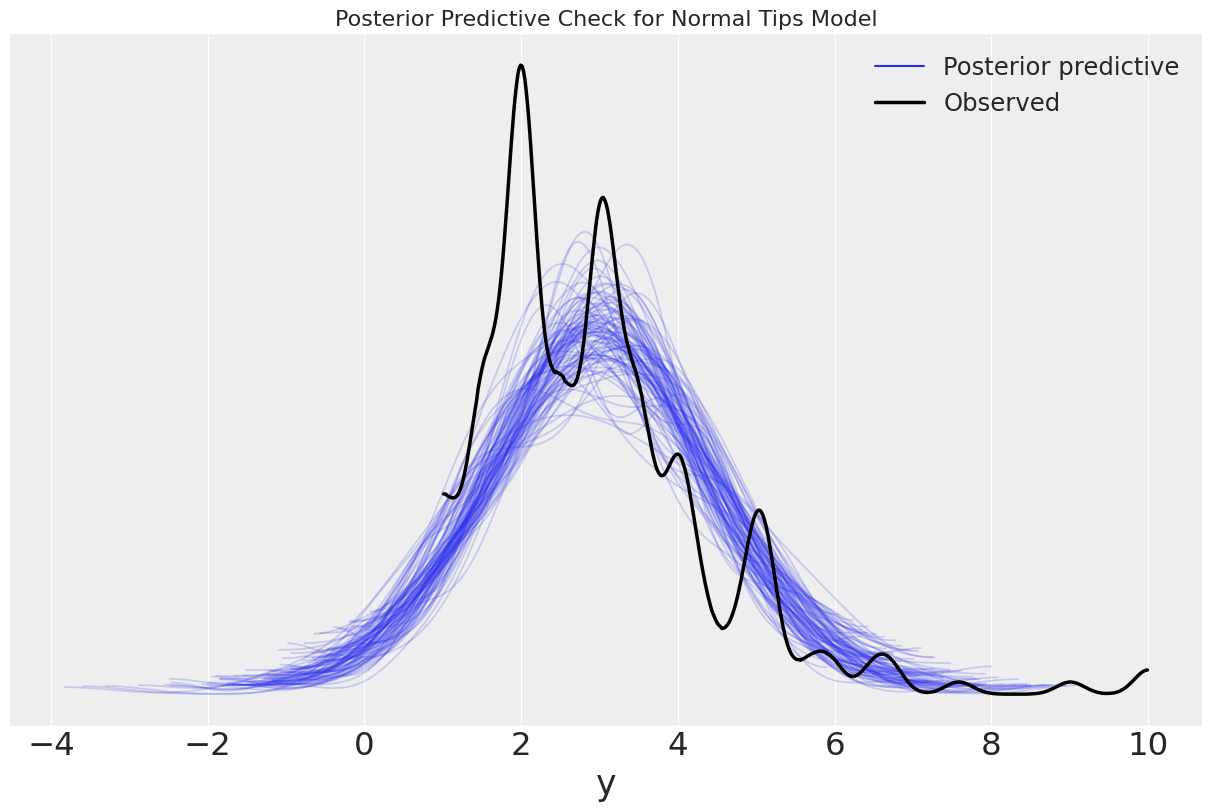

In [27]:
tips_normal = az.from_numpyro(mcmc, posterior_predictive=y_pred_normal, )
# tips_normal = az.from_pymc3(trace=trace_normal, posterior_predictive=y_pred_normal)
ax = az.plot_ppc(tips_normal, figsize=(12,8), mean=False)
ax.set_title("Posterior Predictive Check for Normal Tips Model");
# axes[0].set_title("Posterior Predictive Check for Normal Tips Model");

### Shared $\nu$ across all groups

In [28]:
def model(obs=None):
    # Priors
    μ = numpyro.sample('μ', dist.Normal(loc=0, scale=10), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10), sample_shape=(groups,))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
    
    # Likelihood
    y = numpyro.sample('y', dist.StudentT(ν, loc=μ[idx], scale=σ[idx]), obs=obs)
    
kernel = NUTS(model)
mcmc_nu_shared = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_nu_shared.run(random.PRNGKey(1), obs=tip)

pred = Predictive(model=mcmc_nu_shared.sampler.model, posterior_samples=mcmc_nu_shared.get_samples(), return_sites=['y'])
y_pred_nu_shared = pred(random.PRNGKey(seed))

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 5180.11it/s, 7 steps of size 4.97e-01. acc. prob=0.93]


In [29]:
y_pred_nu_shared['y'] = y_pred_nu_shared['y'][:100]

In [30]:
y_pred_nu_shared['y']

DeviceArray([[3.3804502 , 1.855169  , 2.6588318 , ..., 2.3689137 ,
              3.9253676 , 1.7528629 ],
             [3.7585166 , 4.7252293 , 2.6407044 , ..., 2.5933318 ,
              6.6557975 , 1.5313852 ],
             [4.1861796 , 3.0742688 , 3.1691594 , ..., 4.770434  ,
              0.99994695, 3.0893745 ],
             ...,
             [6.1282716 , 0.09785277, 2.0844345 , ..., 1.3396584 ,
              4.6238675 , 0.21592183],
             [1.0493304 , 2.8243797 , 3.9303071 , ..., 3.959254  ,
              2.518939  , 0.926102  ],
             [2.820881  , 2.8085551 , 5.292919  , ..., 1.9563518 ,
              3.7566905 , 6.6220255 ]], dtype=float32)

In [31]:
# with pm.Model() as comparing_groups:
#     μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
#     σ = pm.HalfNormal('σ', sd=10, shape=groups)
#     ν = pm.Exponential('ν', 1/30)
    
#     y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν, observed=tip)
    
#     trace_nu_shared = pm.sample(5000)
#     y_pred_nu_shared = pm.sample_posterior_predictive(trace_nu_shared, 100)

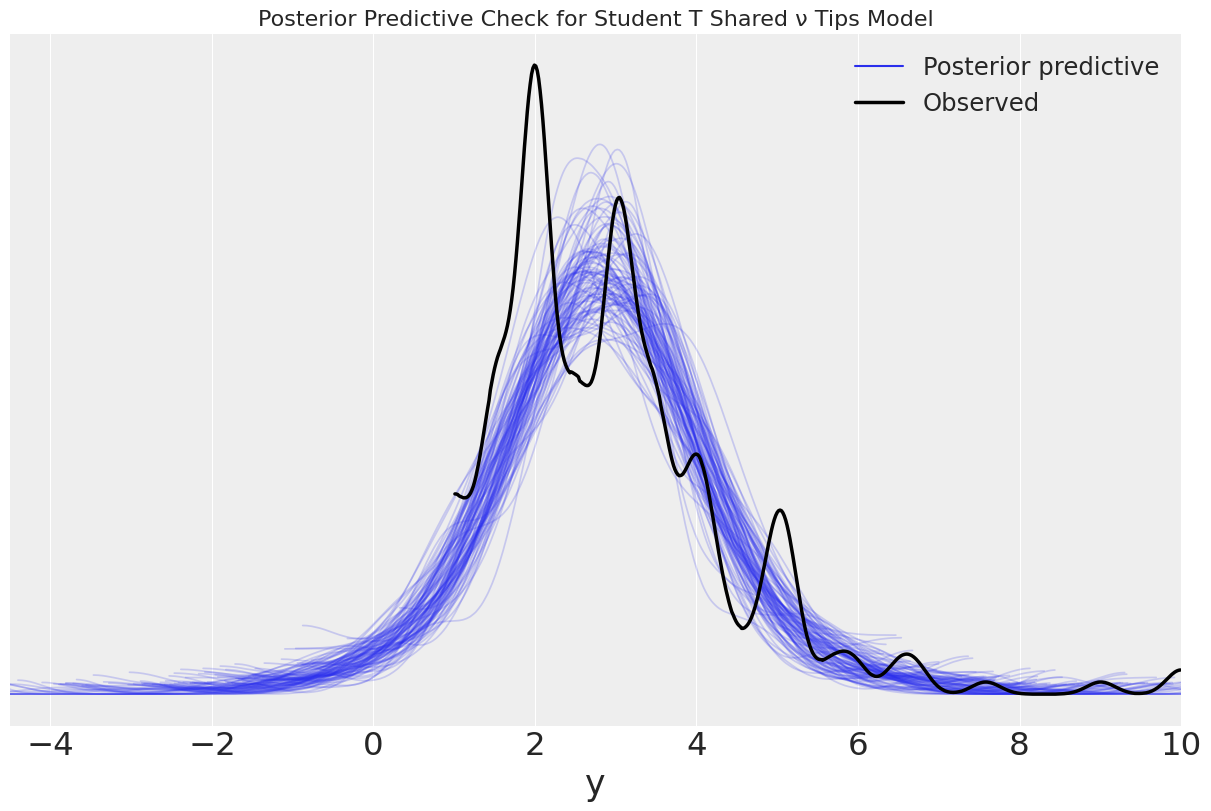

In [32]:
tips_nu_shared = az.from_numpyro(mcmc_nu_shared, posterior_predictive=y_pred_nu_shared)
# tips_normal = az.from_pymc3(trace=trace_normal, posterior_predictive=y_pred_normal)
ax = az.plot_ppc(tips_nu_shared, figsize=(12,8), mean=False)
ax.set_title("Posterior Predictive Check for Student T Shared ν Tips Model")
ax.set_xlim(-4.5,10);
# axes[0].set_title("Posterior Predictive Check for Normal Tips Model");

### One $\nu$ per group

In [33]:
def model(obs=None):
    with numpyro.handlers.seed(rng_seed=1234):
        μ = numpyro.sample('μ', dist.Normal(loc=0, scale=10), sample_shape=(groups,))
        σ = numpyro.sample('σ', dist.HalfNormal(scale=10), sample_shape=(groups,))
        ν = numpyro.sample('ν', dist.Exponential(rate=1/30).expand([groups]))
    
    # Likelihood
    y = numpyro.sample('y', dist.StudentT(ν[idx], loc=μ[idx], scale=σ[idx]), obs=obs)

In [34]:
kernel = NUTS(model)

In [35]:
tip.shape

(244,)

In [36]:
groups

4

In [37]:
mcmc_nu_per_group = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_nu_per_group.run(random.PRNGKey(1), obs=tip)

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 2147.20it/s, 7 steps of size 5.34e-01. acc. prob=0.86]


In [38]:
pred = Predictive(model=mcmc_nu_per_group.sampler.model, posterior_samples=mcmc_nu_per_group.get_samples(), return_sites=['y'])
y_pred_nu_per_group = pred(random.PRNGKey(seed))

In [39]:
y_pred_nu_per_group['y'] = y_pred_nu_per_group['y'][:100]

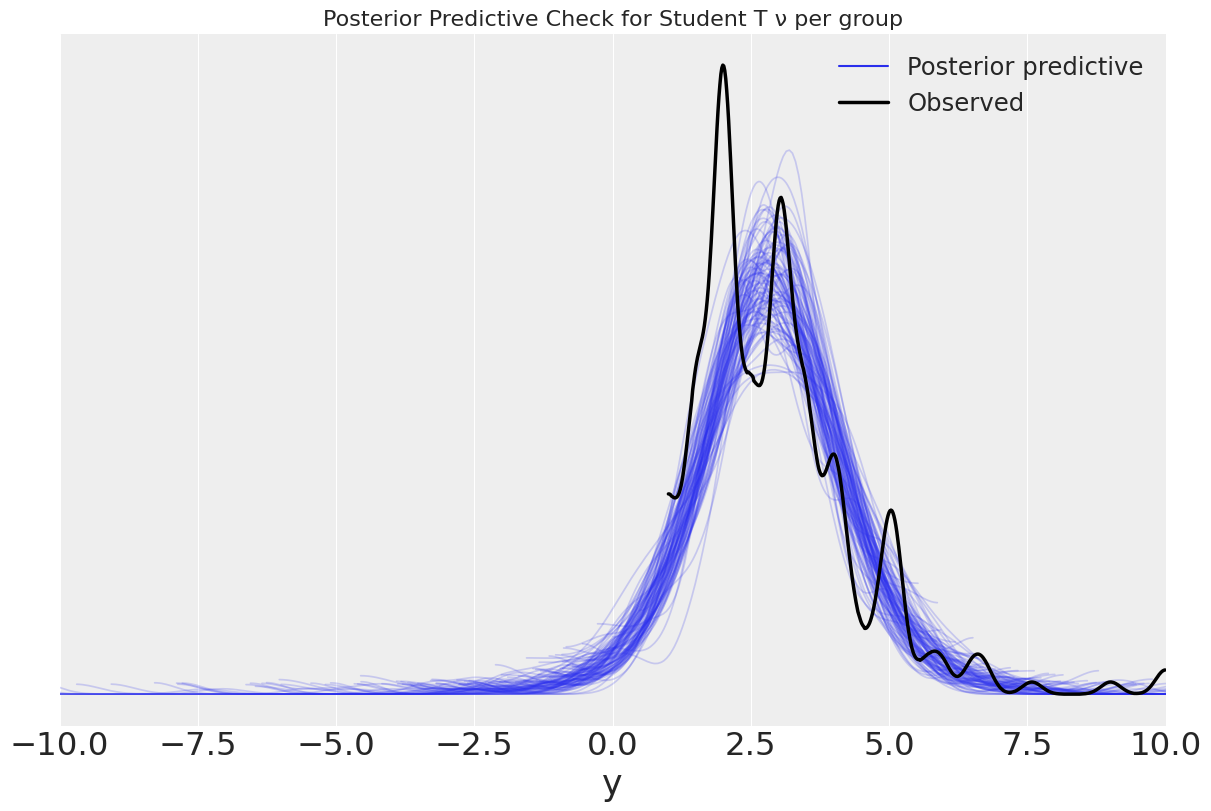

In [40]:
tips_nu_per_group = az.from_numpyro(posterior=mcmc_nu_per_group, posterior_predictive=y_pred_nu_per_group)
ax = az.plot_ppc(tips_nu_per_group, figsize=(12,8), mean=False)
ax.set_title("Posterior Predictive Check for Student T ν per group")
ax.set_xlim(-10,10);

## Question 6
***

*Compute the probability of superiority directly from the posterior (without computing Cohen's d first). You can use the `pm.sample_posterior_predictive()` function to take a sample from each group. Is it really different from the calculation assuming normality? Can you explain the result?*

The goal is to calculate Cohen's D numerically. We'll do that in 3 steps:

1. Fit a distribution of parameters to our data
2. Generate posterior predictive distributions for our groups
3. Pick data points at random from each group and compare the datapoints in each group

### Step 1: Estimate model parameters per group

In [41]:
tips = pd.read_csv('../data/tips.csv')
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(jnp.unique(idx))

In [42]:
def model(obs=None):
    # Priors
    μ = numpyro.sample('μ', dist.Normal(loc=0, scale=10), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10), sample_shape=(groups,))
    
    # Likelihood
    y = numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs)
    
kernel = NUTS(model)
mcmc_cg = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_cg.run(random.PRNGKey(1), obs=tip)

pred = Predictive(model=mcmc_cg.sampler.model, posterior_samples=mcmc_cg.get_samples(), return_sites=['y'])
ppc_cg = pred(random.PRNGKey(seed))

ppc_cg['y'] = ppc_cg['y'][:500]

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 5668.81it/s, 7 steps of size 7.45e-01. acc. prob=0.87]


In [43]:
flat_tips = az.from_numpyro(posterior=mcmc_cg)
tips_gaussian = az.summary(flat_tips)
tips_gaussian

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],2.767,0.164,2.473,3.085,0.003,0.002,3093.0,1329.0,1.0
μ[1],2.726,0.269,2.240,3.243,0.005,0.004,2525.0,1487.0,1.0
μ[2],2.997,0.175,2.636,3.301,0.003,0.002,2913.0,1306.0,1.0
μ[3],3.256,0.143,2.980,3.503,0.003,0.002,2935.0,1481.0,1.0
σ[0],1.270,0.119,1.058,1.492,0.002,0.001,3532.0,1564.0,1.0
σ[1],1.109,0.212,0.737,1.499,0.005,0.003,2613.0,1435.0,1.0
σ[2],1.654,0.125,1.435,1.897,0.002,0.002,3144.0,1403.0,1.0
σ[3],1.252,0.100,1.064,1.436,0.002,0.001,3178.0,1464.0,1.0


### Step 2: Get posterior predictive values per group
In our case, let's see if Sunday is superior to Thursday in regards to tips. 

In our code, recall that:
* We have 244 items
* We encoded the string labels of days into "codes" or integers
* Sunday was encoded as 3, Thursday was encoded as 0

In [44]:
# Get our model's predictions for possible tips on Thursday and Sunday
posterior_predictive_thursday = ppc_cg["y"][:,idx==0].flatten()
posterior_predictive_sunday = ppc_cg["y"][:,idx==3].flatten()

Just to get a sense of the distributions, let's plot them:

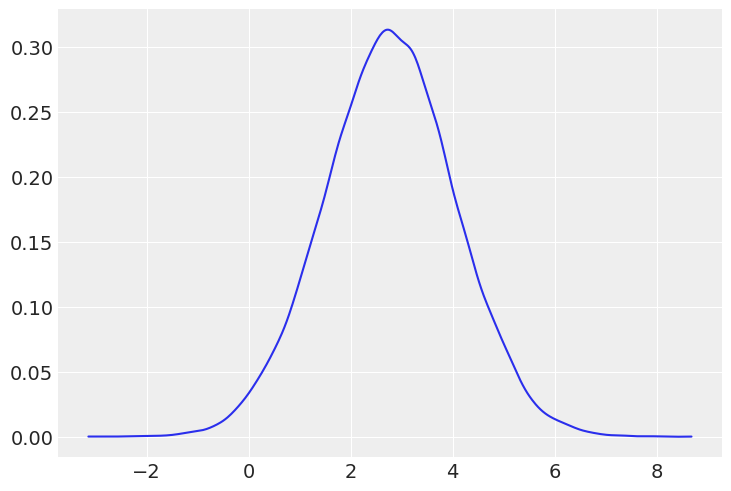

In [45]:
az.plot_kde(posterior_predictive_thursday);

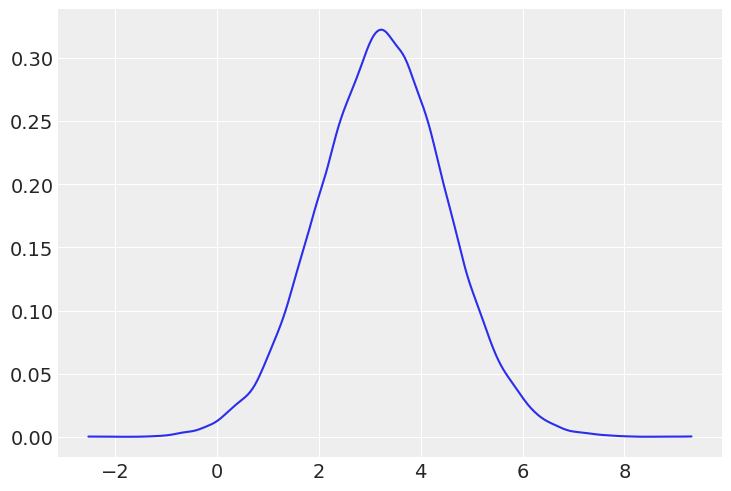

In [46]:
az.plot_kde(posterior_predictive_sunday);

From visual inspection, it's hard to see the difference between the two groups.

### Step 3: Pick data points at random from each group and compare

Let's numerically simulate Cohen's D by drawing random samples from both posterior predictive distributions and naively calculating probability

In [47]:
count_superior = 0
samples = 1000
for _ in range(samples):
    thursday_tip_draw = random.choice(key=random.PRNGKey(_), a=posterior_predictive_thursday)
    sunday_tip_draw = random.choice(key=random.PRNGKey(_), a=posterior_predictive_sunday)
    if thursday_tip_draw > sunday_tip_draw:
        count_superior +=1
        
count_superior/samples

0.381

.397 is very similar to the calculation we obtained in Figure 2.18. This means that, given a tip on Thursday, there is only a 4 in 10 chance that it will be higher than a tip on Sunday. In other words, you should sign up for Sunday shifts if you're looking to make extra money! I encourage you to try changing the idx values to compare other groups.

For reference, another, more efficient way to compute Cohen's D is possible with numpy broadcasting. The code below is functionally identical to the code above, but by using numpy broadcasting we can write less code and the computation is completed more efficiently:

In [48]:
thursday_tip_draws = random.choice(key=random.PRNGKey(1), a=posterior_predictive_thursday, replace=True, shape=(1000,))
sunday_tip_draws = random.choice(key=random.PRNGKey(2), a=posterior_predictive_sunday, replace=True, shape=(1000,))

(thursday_tip_draws > sunday_tip_draws).mean()

DeviceArray(0.406, dtype=float32)

## Question 7
***

*Repeat the exercise we did with `model_h`. This time, without hierarchical structure, use a flat prior such as $Beta(1,1)$. Compare the results of both models.*

In [49]:
# Generate data
N_samples = [30, 30, 30]
G_samples = [18, 3, 3] # [18, 18, 18]  # [3, 3, 3]  

group_idx = jnp.repeat(jnp.arange(len(N_samples)), jnp.asarray(N_samples))
data = []
for i in range(len(N_samples)):
    data.extend(jnp.repeat(jnp.asarray([1, 0]), jnp.asarray([G_samples[i], N_samples[i]-G_samples[i]])))

In [50]:
# Baseline model
def model(obs=None):
    # Priors
    μ = numpyro.sample('μ', dist.Beta(concentration1=1., concentration0=1.))
    κ = numpyro.sample('κ', dist.HalfNormal(scale=10))
                       
    θ = numpyro.sample('θ', dist.Beta(concentration1=μ*κ, concentration0=(1.0-μ)*κ), sample_shape=(len(N_samples),))
    
    # Likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ[group_idx]), obs=obs)
    
kernel = NUTS(model)
mcmc_h = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_h.run(random.PRNGKey(1), obs=jnp.asarray(data))

pred = Predictive(model=mcmc_h.sampler.model, posterior_samples=mcmc_h.get_samples(), return_sites=['y'])
ppc_h = pred(random.PRNGKey(seed))

ppc_h['y'] = ppc_h['y'][:500]

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 5774.81it/s, 7 steps of size 4.86e-01. acc. prob=0.93]


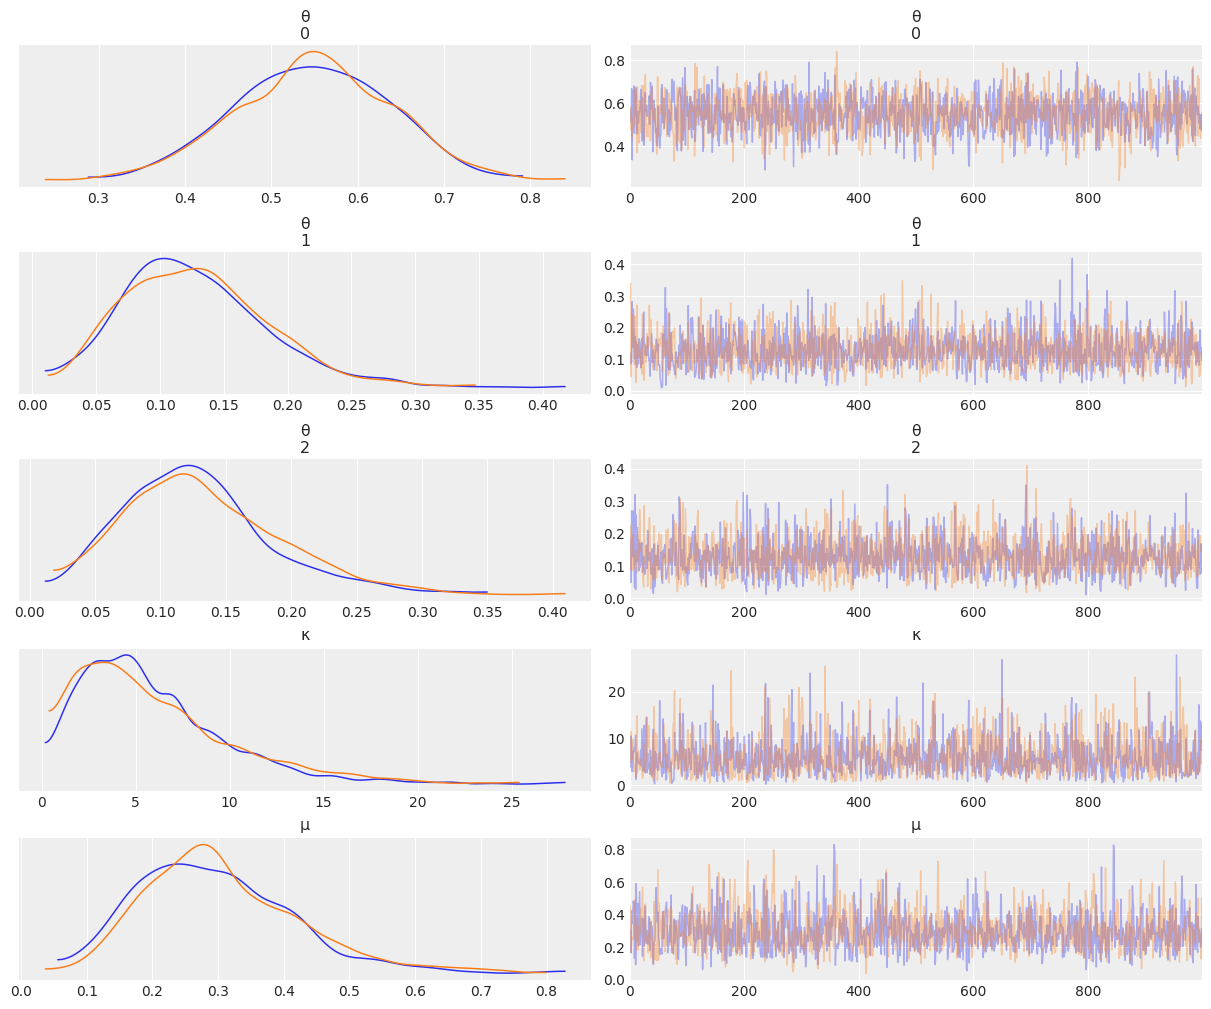

In [51]:
az.plot_trace(mcmc_h, compact=False);

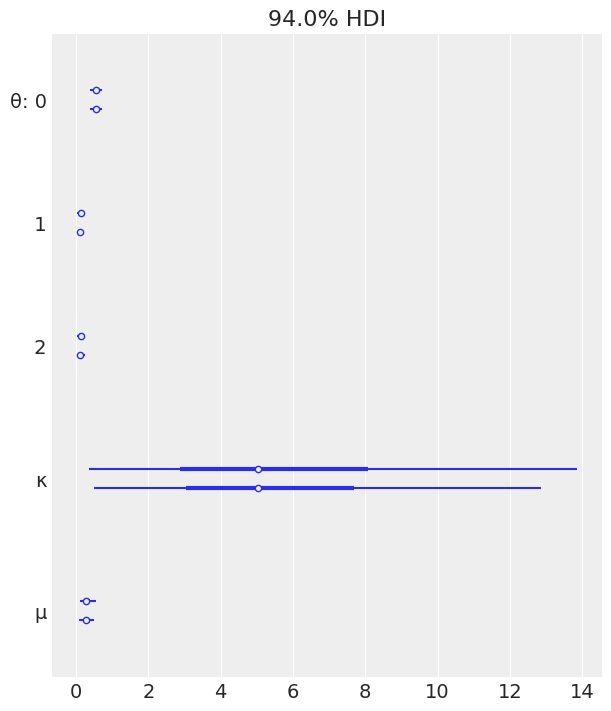

In [52]:
az.plot_forest(mcmc_h);

In [53]:
baseline_summary = az.summary(mcmc_h)
baseline_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[0],0.548,0.089,0.378,0.708,0.002,0.001,1870.0,1528.0,1.00
θ[1],0.128,0.056,0.027,0.228,0.001,0.001,1885.0,1188.0,1.00
θ[2],0.130,0.058,0.028,0.235,0.001,0.001,2038.0,1368.0,1.00
κ,5.980,4.084,0.523,13.470,0.105,0.074,1404.0,1356.0,1.00
μ,0.301,0.120,0.105,0.539,0.003,0.002,1421.0,1371.0,1.01


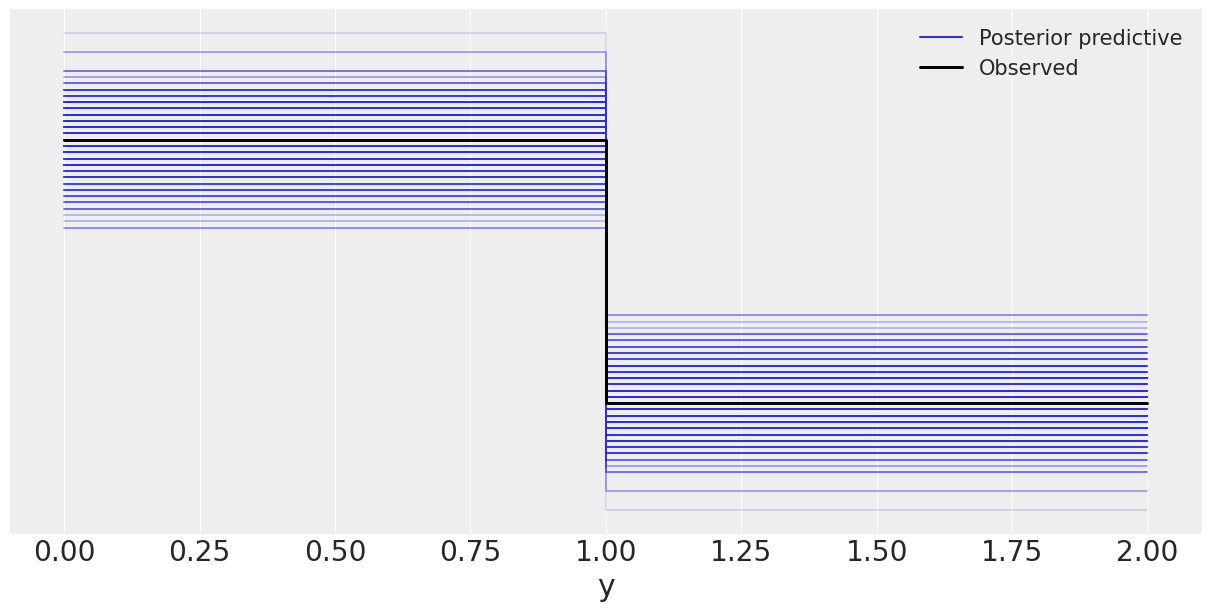

In [54]:
baseline_model = az.from_numpyro(posterior=mcmc_h, posterior_predictive=ppc_h)
az.plot_ppc(baseline_model, figsize=(12,6), mean=False);

In [55]:
# baseline_model = az.from_pymc3(trace=trace_h, posterior_predictive=ppc_h)
# az.plot_ppc(baseline_model, figsize=(12,6), mean=False);

In [56]:
# Flat model
def model(obs=None):
    # Priors
    μ = numpyro.sample('μ', dist.Beta(concentration1=1., concentration0=1.))
    κ = numpyro.sample('κ', dist.HalfNormal(scale=10))
                       
    θ = numpyro.sample('θ', dist.Beta(concentration1=μ*κ, concentration0=(1.0-μ)*κ))
    
    # Likelihood
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
    
kernel = NUTS(model)
mcmc_non_h = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_non_h.run(random.PRNGKey(1), obs=jnp.asarray(data))

pred = Predictive(model=mcmc_non_h.sampler.model, posterior_samples=mcmc_non_h.get_samples(), return_sites=['y'])
ppc_non_h = pred(random.PRNGKey(seed))

ppc_non_h['y'] = ppc_non_h['y'][:500]

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 6294.30it/s, 7 steps of size 5.73e-01. acc. prob=0.94]


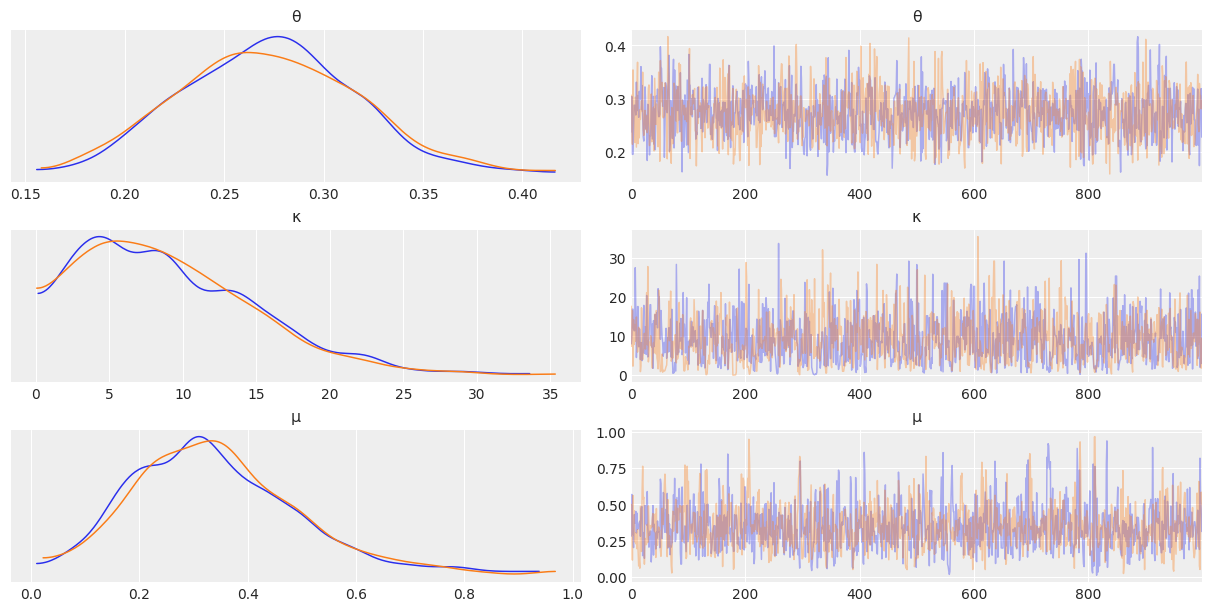

In [57]:
az.plot_trace(mcmc_non_h, compact=False);

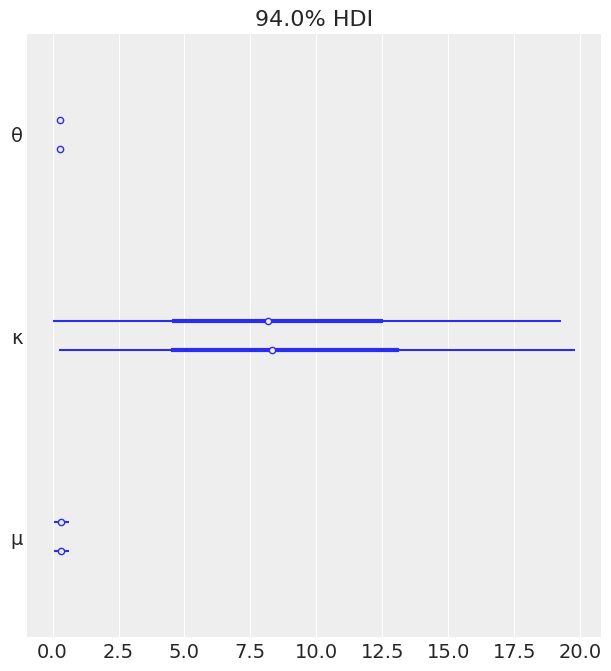

In [58]:
az.plot_forest(mcmc_non_h);

In [59]:
flat_summary = az.summary(mcmc_non_h)
flat_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.272,0.045,0.186,0.354,0.001,0.001,1744.0,1512.0,1.0
κ,9.159,5.936,0.029,19.496,0.176,0.125,901.0,698.0,1.0
μ,0.343,0.156,0.049,0.620,0.004,0.003,1370.0,991.0,1.0


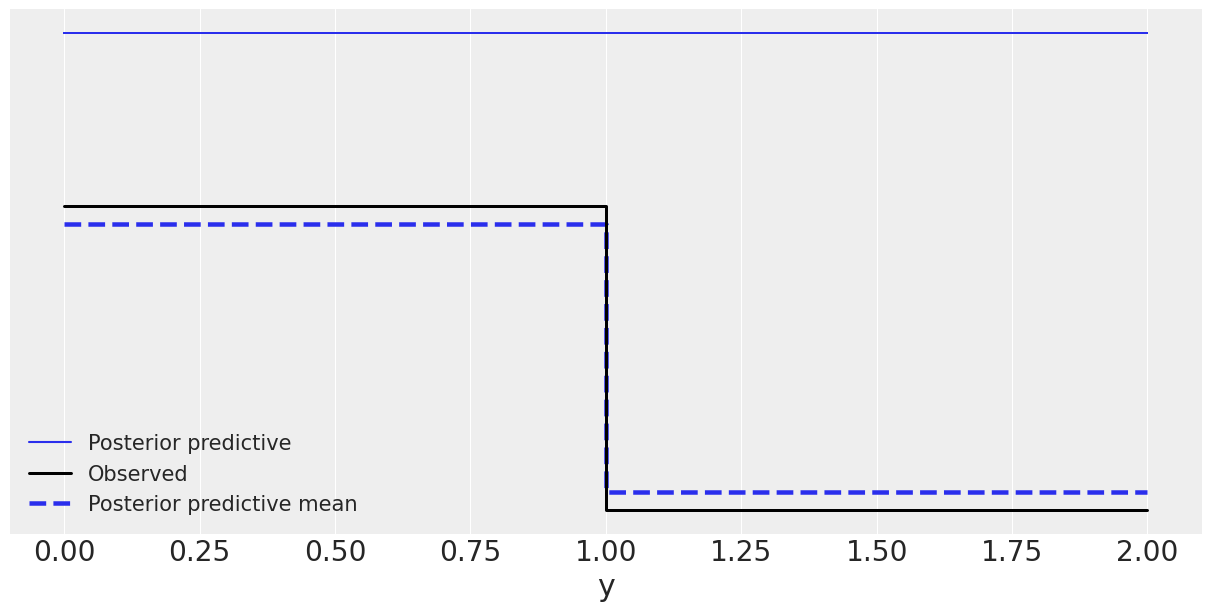

In [60]:
flat_model = az.from_numpyro(posterior=mcmc_non_h, posterior_predictive=ppc_non_h)
az.plot_ppc(flat_model, figsize=(12,6));

#### Summary comparison

In [61]:
pd.concat([baseline_summary, flat_summary])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[0],0.548,0.089,0.378,0.708,0.002,0.001,1870.0,1528.0,1.00
θ[1],0.128,0.056,0.027,0.228,0.001,0.001,1885.0,1188.0,1.00
θ[2],0.130,0.058,0.028,0.235,0.001,0.001,2038.0,1368.0,1.00
κ,5.980,4.084,0.523,13.470,0.105,0.074,1404.0,1356.0,1.00
μ,0.301,0.120,0.105,0.539,0.003,0.002,1421.0,1371.0,1.01
θ,0.272,0.045,0.186,0.354,0.001,0.001,1744.0,1512.0,1.00
κ,9.159,5.936,0.029,19.496,0.176,0.125,901.0,698.0,1.00
μ,0.343,0.156,0.049,0.620,0.004,0.003,1370.0,991.0,1.00


#### Discussion
In the hiearchical model, we get three estimates of $\theta$, one per each group. So, by using a hierarchical model, we're able to obtain the range of $\theta$ parameters per group, and not just the average $\theta$ parameter for all groups.

## Question 8
***

*Create a hierarchical version of the tips example by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.*

Refer to Question 6 for the non-pooled version of the model.

In [62]:
def model(obs=None):
    # Priors
    pooled_mean = numpyro.sample('pooled_mean', dist.Normal(loc=0., scale=10.))
    μ = numpyro.sample('μ', dist.Normal(loc=pooled_mean, scale=1.), sample_shape=(groups,))
    
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.), sample_shape=(groups,))
    
    # Likelihood
    y = numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs)
    
kernel = NUTS(model)
mcmc_pooled_tips = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2, chain_method='sequential')
mcmc_pooled_tips.run(random.PRNGKey(1), obs=tip)

pred = Predictive(model=mcmc_pooled_tips.sampler.model, posterior_samples=mcmc_pooled_tips.get_samples(), return_sites=['y'])
ppc_pooled_tips = pred(random.PRNGKey(seed))

ppc_pooled_tips['y'] = ppc_pooled_tips['y'][:500]

sample: 100%|██████████████████████████| 1500/1500 [00:00<00:00, 5603.35it/s, 3 steps of size 5.90e-01. acc. prob=0.92]


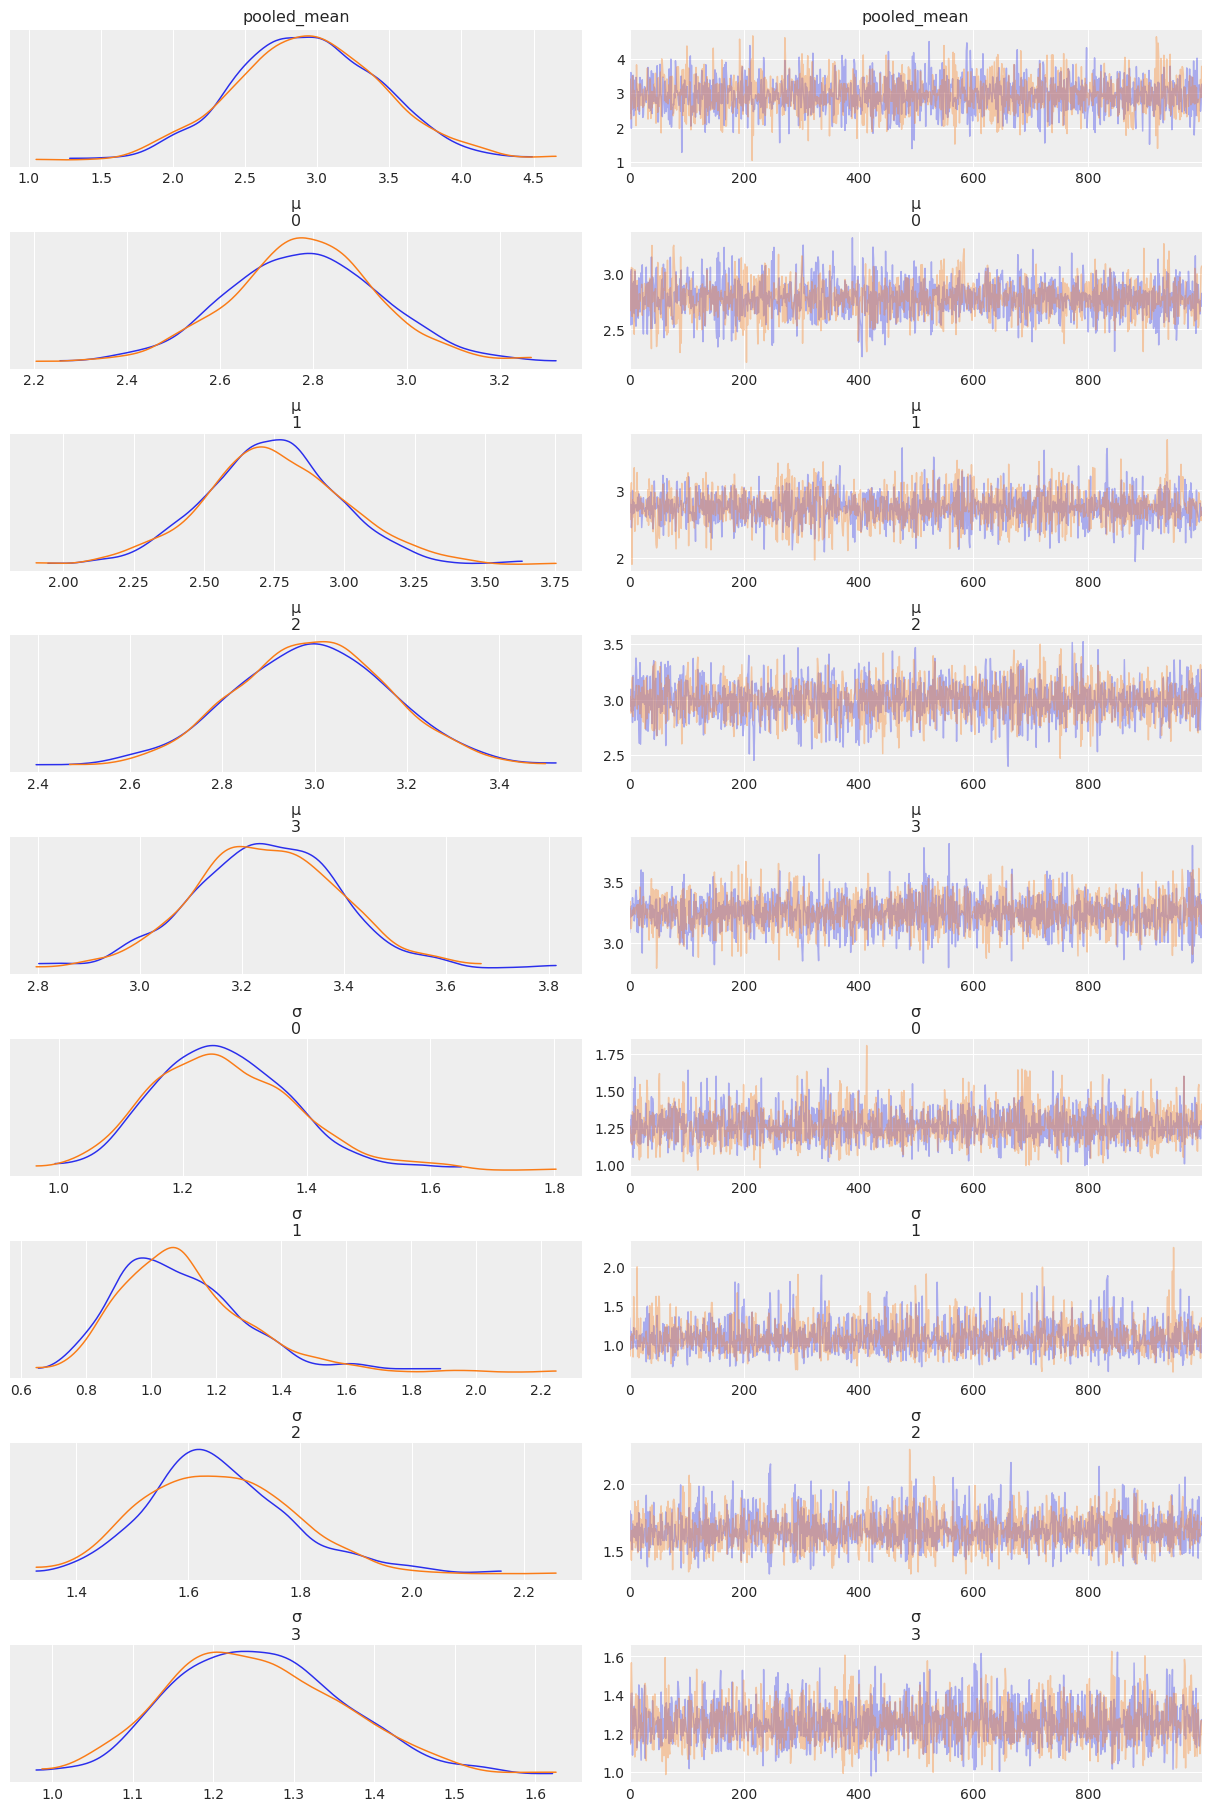

In [63]:
az.plot_trace(mcmc_pooled_tips, compact=False);

In [64]:
pooled_tips_dataset = az.from_numpyro(posterior=mcmc_pooled_tips)
tips_pooled_summary = az.summary(pooled_tips_dataset)
tips_pooled_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pooled_mean,2.940,0.514,1.938,3.855,0.008,0.006,4705.0,1374.0,1.0
μ[0],2.779,0.161,2.480,3.088,0.003,0.002,3150.0,1261.0,1.0
μ[1],2.746,0.242,2.295,3.212,0.005,0.004,2434.0,1216.0,1.0
μ[2],2.995,0.168,2.692,3.322,0.003,0.002,3523.0,1659.0,1.0
μ[3],3.248,0.142,2.974,3.503,0.002,0.002,3447.0,1230.0,1.0
σ[0],1.266,0.114,1.048,1.466,0.002,0.001,3751.0,1306.0,1.0
σ[1],1.095,0.200,0.731,1.432,0.004,0.003,3429.0,1465.0,1.0
σ[2],1.654,0.130,1.435,1.916,0.002,0.001,4926.0,1584.0,1.0
σ[3],1.256,0.108,1.061,1.457,0.002,0.001,3472.0,1427.0,1.0


In [65]:
pd.concat([tips_gaussian, tips_pooled_summary])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],2.767,0.164,2.473,3.085,0.003,0.002,3093.0,1329.0,1.0
μ[1],2.726,0.269,2.240,3.243,0.005,0.004,2525.0,1487.0,1.0
μ[2],2.997,0.175,2.636,3.301,0.003,0.002,2913.0,1306.0,1.0
μ[3],3.256,0.143,2.980,3.503,0.003,0.002,2935.0,1481.0,1.0
σ[0],1.270,0.119,1.058,1.492,0.002,0.001,3532.0,1564.0,1.0
σ[1],1.109,0.212,0.737,1.499,0.005,0.003,2613.0,1435.0,1.0
σ[2],1.654,0.125,1.435,1.897,0.002,0.002,3144.0,1403.0,1.0
σ[3],1.252,0.100,1.064,1.436,0.002,0.001,3178.0,1464.0,1.0
pooled_mean,2.940,0.514,1.938,3.855,0.008,0.006,4705.0,1374.0,1.0
μ[0],2.779,0.161,2.480,3.088,0.003,0.002,3150.0,1261.0,1.0


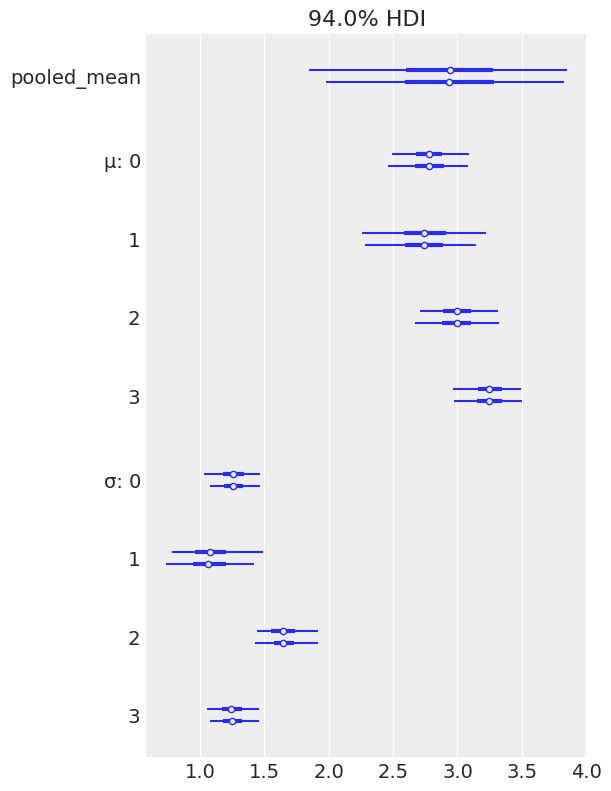

In [66]:
az.plot_forest(pooled_tips_dataset);

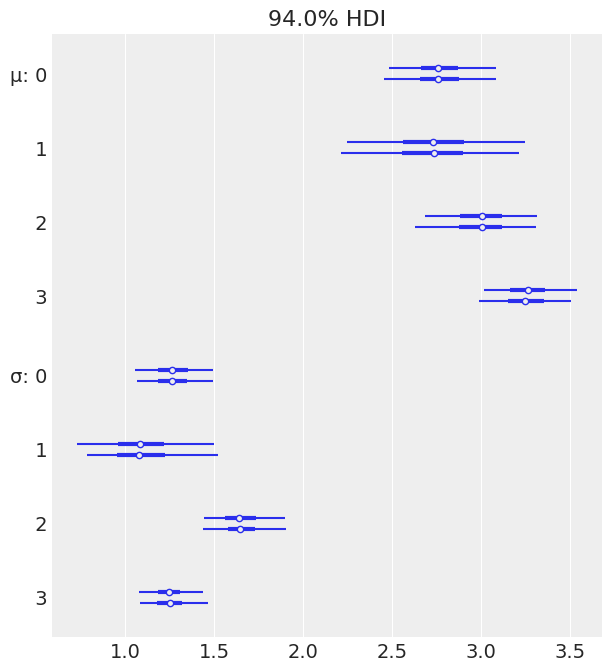

In [67]:
az.plot_forest(flat_tips);

## Question 9
***

*PyMC3 can create **directed acyclic graphs (DAGs)** from models that are very similar to Kruschke's diagrams. You can obtain them using the `pm.model_to_graphviz()` function. To generate DAGs, you may need to install graphviz using the command `conda install -c conda-forge python-graphviz`. Generate a DAG for each model in this chapter.*

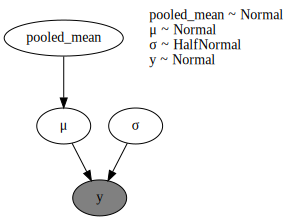

In [68]:
numpyro.render_model(model, model_args=(tip,), render_distributions=True)

In [69]:
# pm.model_to_graphviz(pooled_mu_tips)

*A last note before finishing up: besides the exercises you'll find at the end of each chapter, you can always try to (and probably should) think of problems you are interested in and how to apply what you have learned to that problem. Maybe you will need to define your problem in a different way, or maybe you will need to expand or modify the models you have learned. If you think this task is beyond your current skills, note down the problem and come back to it after reading another chapter in this book. Eventually, if the book does not answer your questions, check the [PyMC3 examples](https://docs.pymc.io/nb_examples/index.html) or ask a question on [PyMC's Discourse](https://discourse.pymc.io/).*